In [2]:
# Run this whenever you shut down the VM
# !pip3 install cassandra-driver --user
# !pip install folium
# !pip install --upgrade pip
!conda install -y -c anaconda seaborn=0.9.0


Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/python3

  added / updated specs: 
    - seaborn=0.9.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    numpy-base-1.14.3          |   py36hdbf6ddf_2         4.1 MB  anaconda
    openssl-1.0.2t             |       h7b6447c_1         3.1 MB  anaconda
    patsy-0.5.1                |           py36_0         380 KB  anaconda
    ca-certificates-2019.10.16 |                0         131 KB  anaconda
    statsmodels-0.10.1         |   py36hdd07704_0         9.6 MB  anaconda
    pandas-0.25.3              |   py36he6710b0_0        11.5 MB  anaconda
    certifi-2019.9.11          |           py36_0         154 KB 

In [3]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

In [4]:
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider
from cassandra.query import SimpleStatement
from cassandra import ConsistencyLevel
import datetime


import pandas as pd

def pandas_factory(colnames, rows):
    return pd.DataFrame(rows, columns=colnames)
def connect():
    cluster = Cluster(
        contact_points=['172.31.22.32'], 
        auth_provider = PlainTextAuthProvider(username='tomcat', password='drawsweb'),
        connect_timeout = 20,
        control_connection_timeout=None
    )
    session = cluster.connect()
    session.set_keyspace('disruptionwarning')
    session.row_factory = pandas_factory
    session.default_fetch_size = 1000000 #needed for large queries, otherwise driver will do pagination. Default is 50000.
    return session

session=connect()

# Set variables for analysis

In [40]:
dest='WSSS'
fromdt=datetime.date(2019,11,4)
todt=datetime.date(2019,11,10)


In [41]:
# Flights added to the registry from flightplans_destination table
# SELECT * FROM flightplans_destination where dest = 'KSFO' AND airline='UAL' and flightno='2744' and departure > '2019-10-13'  allow filtering;
query="SELECT * FROM arrival_kpis where dest = ? and datetime >= ? and datetime <= ?  allow filtering"
fp_kpi_stmt=session.prepare(query)
fp_kpi_stmt.consistency_level = ConsistencyLevel.LOCAL_ONE

rows_kpi = session.execute(fp_kpi_stmt, [dest,fromdt,todt])
df_kpi = rows_kpi._current_rows 
df_kpi.head()


,dest,datetime,id,flights,matching,pct80,pct90,pct95,perf,total
0,WSSS,2019-11-04,1,7,12,8.0,13.0,12.0,92.0,13
1,WSSS,2019-11-04,10,17,21,8.0,14.0,12.0,70.0,30
2,WSSS,2019-11-04,11,17,24,8.0,14.0,15.0,80.0,30
3,WSSS,2019-11-04,12,17,16,9.0,10.0,11.0,53.0,30
4,WSSS,2019-11-04,13,17,14,8.0,11.0,10.0,47.0,30


In [42]:
df_kpi.groupby('datetime')
df_kpi.sort_values(['datetime','id']).head()
# df_kpi['']

,dest,datetime,id,flights,matching,pct80,pct90,pct95,perf,total
0,WSSS,2019-11-04,1,7,12,8.0,13.0,12.0,92.0,13
1,WSSS,2019-11-04,10,17,21,8.0,14.0,12.0,70.0,30
2,WSSS,2019-11-04,11,17,24,8.0,14.0,15.0,80.0,30
3,WSSS,2019-11-04,12,17,16,9.0,10.0,11.0,53.0,30
4,WSSS,2019-11-04,13,17,14,8.0,11.0,10.0,47.0,30


In [43]:
# filter = df_kpi["id"]=="1"
# df_kpi.where(filter,inplace=True)
# df_1day=df_kpi[ (df_kpi['datetime'] >= '2019-11-04 00:00:00') & (df_kpi['datetime'] <= '2019-11-04 23:00:00')]
df_1day=df_kpi[ (df_kpi['datetime'] <= '2019-11-04 23:00:00')]
df_1day=df_1day[df_1day['id']=='1']
df_1day

,dest,datetime,id,flights,matching,pct80,pct90,pct95,perf,total
0,WSSS,2019-11-04 00:00:00,1,7,12,8.0,13.0,12.0,92.0,13
13,WSSS,2019-11-04 01:00:00,1,3,6,1.0,6.0,6.0,100.0,6
26,WSSS,2019-11-04 02:00:00,1,1,2,3.0,3.0,3.0,100.0,2
39,WSSS,2019-11-04 03:00:00,1,2,4,2.0,2.0,2.0,100.0,4
52,WSSS,2019-11-04 04:00:00,1,0,0,0.0,0.0,0.0,0.0,0
65,WSSS,2019-11-04 05:00:00,1,1,2,5.0,5.0,5.0,100.0,2
78,WSSS,2019-11-04 06:00:00,1,0,0,0.0,0.0,0.0,0.0,0
91,WSSS,2019-11-04 07:00:00,1,5,9,2.0,6.0,6.0,100.0,9
104,WSSS,2019-11-04 08:00:00,1,8,15,2.0,0.0,6.0,94.0,16
117,WSSS,2019-11-04 09:00:00,1,9,10,6.0,15.0,10.0,59.0,17


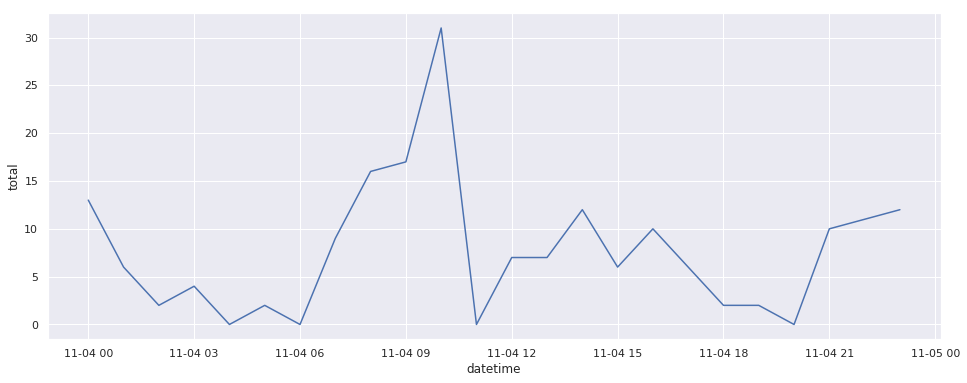

In [39]:
plt.figure(figsize=(16, 6))
ax = sns.lineplot(x="datetime", y="total", data=df_1day)
# ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45)



In [36]:
df_1day.corr()

,flights,matching,pct80,pct90,pct95,perf,total
flights,1.000000,0.912166,0.374675,0.226351,0.302268,0.207672,0.996649
matching,0.912166,1.000000,0.277107,0.170532,0.281539,0.432835,0.917678
pct80,0.374675,0.277107,1.000000,0.579861,0.599702,0.128089,0.379281
pct90,0.226351,0.170532,0.579861,1.000000,0.868037,0.183744,0.217187
pct95,0.302268,0.281539,0.599702,0.868037,1.000000,0.221151,0.291089
perf,0.207672,0.432835,0.128089,0.183744,0.221151,1.000000,0.207071
total,0.996649,0.917678,0.379281,0.217187,0.291089,0.207071,1.000000


In [62]:
df_1id=df_kpi[df_kpi['id']=='2']
df_1id

,dest,datetime,id,flights,matching,pct80,pct90,pct95,perf,total
5,WSSS,2019-11-04 00:00:00,2,16,340,24.0,10.0,14.0,96.0,356
18,WSSS,2019-11-04 01:00:00,2,13,290,1.0,2.0,5.0,98.0,296
31,WSSS,2019-11-04 02:00:00,2,6,90,8.0,3.0,6.0,87.0,103
44,WSSS,2019-11-04 03:00:00,2,7,89,4.0,2.0,3.0,82.0,108
57,WSSS,2019-11-04 04:00:00,2,6,68,11.0,9.0,3.0,83.0,82
...,...,...,...,...,...,...,...,...,...,...
1825,WSSS,2019-11-09 20:00:00,2,3,68,7.0,7.0,7.0,96.0,71
1838,WSSS,2019-11-09 21:00:00,2,13,272,2.0,9.0,2.0,90.0,301
1851,WSSS,2019-11-09 22:00:00,2,18,314,15.0,11.0,0.0,77.0,407
1864,WSSS,2019-11-09 23:00:00,2,20,432,14.0,14.0,5.0,91.0,473


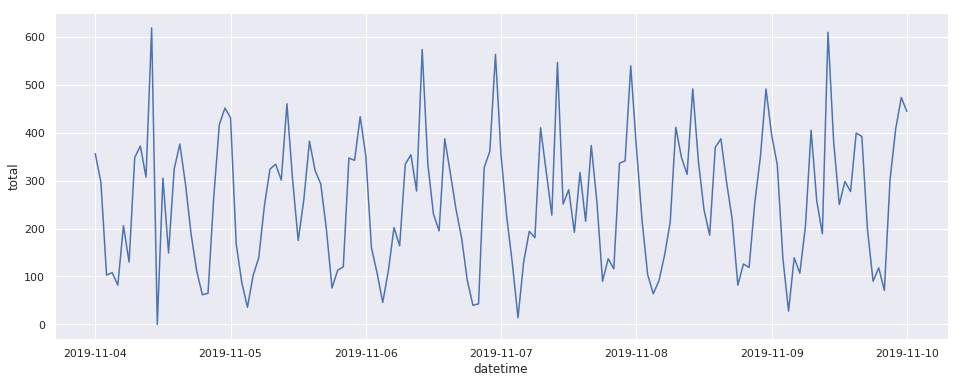

In [63]:
plt.figure(figsize=(16, 6))
ax = sns.lineplot(x="datetime", y="total",data=df_1id)


In [49]:
df_1id.describe()

,flights,matching,pct80,pct90,pct95,perf,total
count,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000
mean,4.351724,6.372414,8.241379,7.317241,7.627586,72.531034,7.772414
std,3.560062,5.313694,14.842823,7.660055,7.925824,32.663702,6.391992
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,2.000000,1.000000,1.000000,67.000000,2.000000
50%,4.000000,6.000000,6.000000,6.000000,6.000000,82.000000,7.000000
75%,6.000000,9.000000,11.000000,11.000000,11.000000,100.000000,11.000000
max,17.000000,27.000000,168.000000,55.000000,55.000000,100.000000,31.000000
